In [ ]:
from google.colab import files
import zipfile
from google.colab import drive

import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL.Image import ImageTransformHandler
from skimage import transform
from numpy.linalg import inv
from numpy import random as r
from PIL import Image
from skimage import draw
from scipy.ndimage import gaussian_filter
from google.colab.patches import cv2_imshow
import copy
from statistics import mean
import math

# drive.mount('/content/drive/')
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
Learning_Rate=1e-5
width = 4032
height = 3024 # image width and height
batchSize=2

TrainFolder = "/content/drive/MyDrive/Senior Design Group 18/Semantic Seg/Train"
# TrainFolder = "/content/drive/MyDrive/Train"
# TrainFolder = "drive/MyDrive/Rutgers Classes/robotics/Robotics Final Project/Pool Table Pictures/Train//"
ListImages=os.listdir(os.path.join(TrainFolder, "Image"))

transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor()])
transformAnn=tf.Compose([tf.ToPILImage(),tf.Resize((height,width),tf.InterpolationMode.NEAREST),tf.ToTensor()])

def ReadRandomImage(): # First lets load random image and  the corresponding annotation
    idx=np.random.randint(0,len(ListImages)) # Select random image
    Img=cv2.imread(os.path.join(TrainFolder, "Image", ListImages[idx]))[:,:,0:3]
    Ball =  cv2.imread(os.path.join(TrainFolder, "Ball", ListImages[idx].replace("jpg","png")),0)
    Table =  cv2.imread(os.path.join(TrainFolder, "Table", ListImages[idx].replace("jpg","png")),0)
    # Stick = cv2.imread(os.path.join(TrainFolder, "Stick", ListImages[idx].replace("jpg","png")),0)
    AnnMap = np.zeros(Img.shape[0:2],np.float32)
    if Table is not None:  AnnMap[ Table > 200 ] = 1
    if Ball is not None:  AnnMap[ Ball > 200 ] = 2
    # if Stick is not None: AnnMap [ Stick > 200 ] = 3
    Img=transformImg(Img)
    AnnMap=transformAnn(AnnMap)
    return Img,AnnMap

# Show all annotation maps to confirm they are being processed correctly
# Used during testing
def ReadEveryImage():
    Imgs = []
    AnnMaps = []
    for idx in range(len(ListImages)):
        Img=cv2.imread(os.path.join(TrainFolder, "Image", ListImages[idx]))[:,:,0:3]
        Ball =  cv2.imread(os.path.join(TrainFolder, "Ball", ListImages[idx].replace("jpg","png")),0)
        Table =  cv2.imread(os.path.join(TrainFolder, "Table", ListImages[idx].replace("jpg","png")),0)
        Stick = cv2.imread(os.path.join(TrainFolder, "Stick", ListImages[idx].replace("jpg","png")),0)
        AnnMap = np.zeros(Img.shape[0:2],np.float32)
        if Table is not None:  AnnMap[ Table > 200 ] = 1
        if Ball is not None:  AnnMap[ Ball > 200 ] = 2
        if Stick is not None: AnnMap [ Stick > 200 ] = 3
        Img=transformImg(Img)
        AnnMap=transformAnn(AnnMap)
        Imgs.append(Img)
        AnnMaps.append(AnnMap)
        # print(ListImages[idx])
        # plt.imshow(AnnMap[0,:,:])
        # plt.show()
    return Imgs, AnnMaps

In [ ]:
Imgs, AnnMaps = ReadEveryImage()

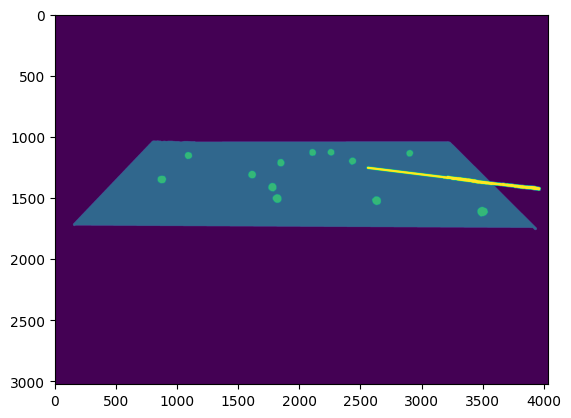

torch.Size([3024, 4032])


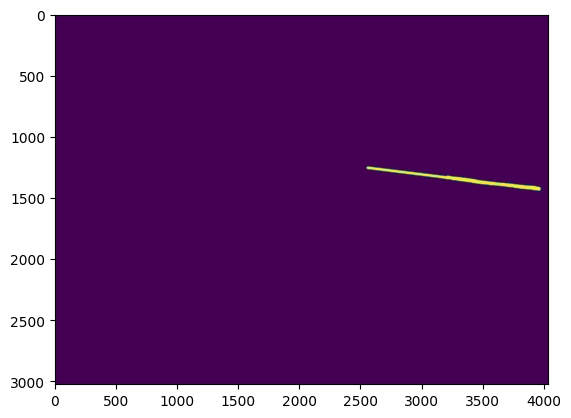

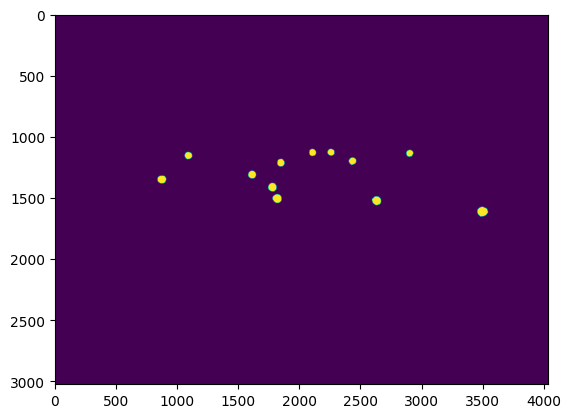

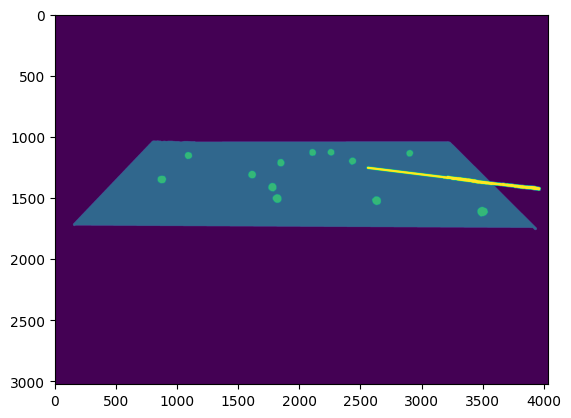

In [ ]:
# Imgs, AnnMaps are list of Images and corresponding Annotation Maps
im_number = 3

plt.imshow(AnnMaps[im_number][0,:,:])
plt.show()
img = AnnMaps[im_number][0,:,:]
print(img.shape)
img_stick = copy.deepcopy(img)
img_ball = copy.deepcopy(img)
img_table = copy.deepcopy(img)
img_stick [ img_stick != 3 ] = 0
plt.imshow(img_stick)
plt.show()
img_ball [ img_ball != 2 ] = 0
plt.imshow(img_ball)
plt.show()
# img_table [ img_table != 1] = 0
plt.imshow(img_table)
plt.show()

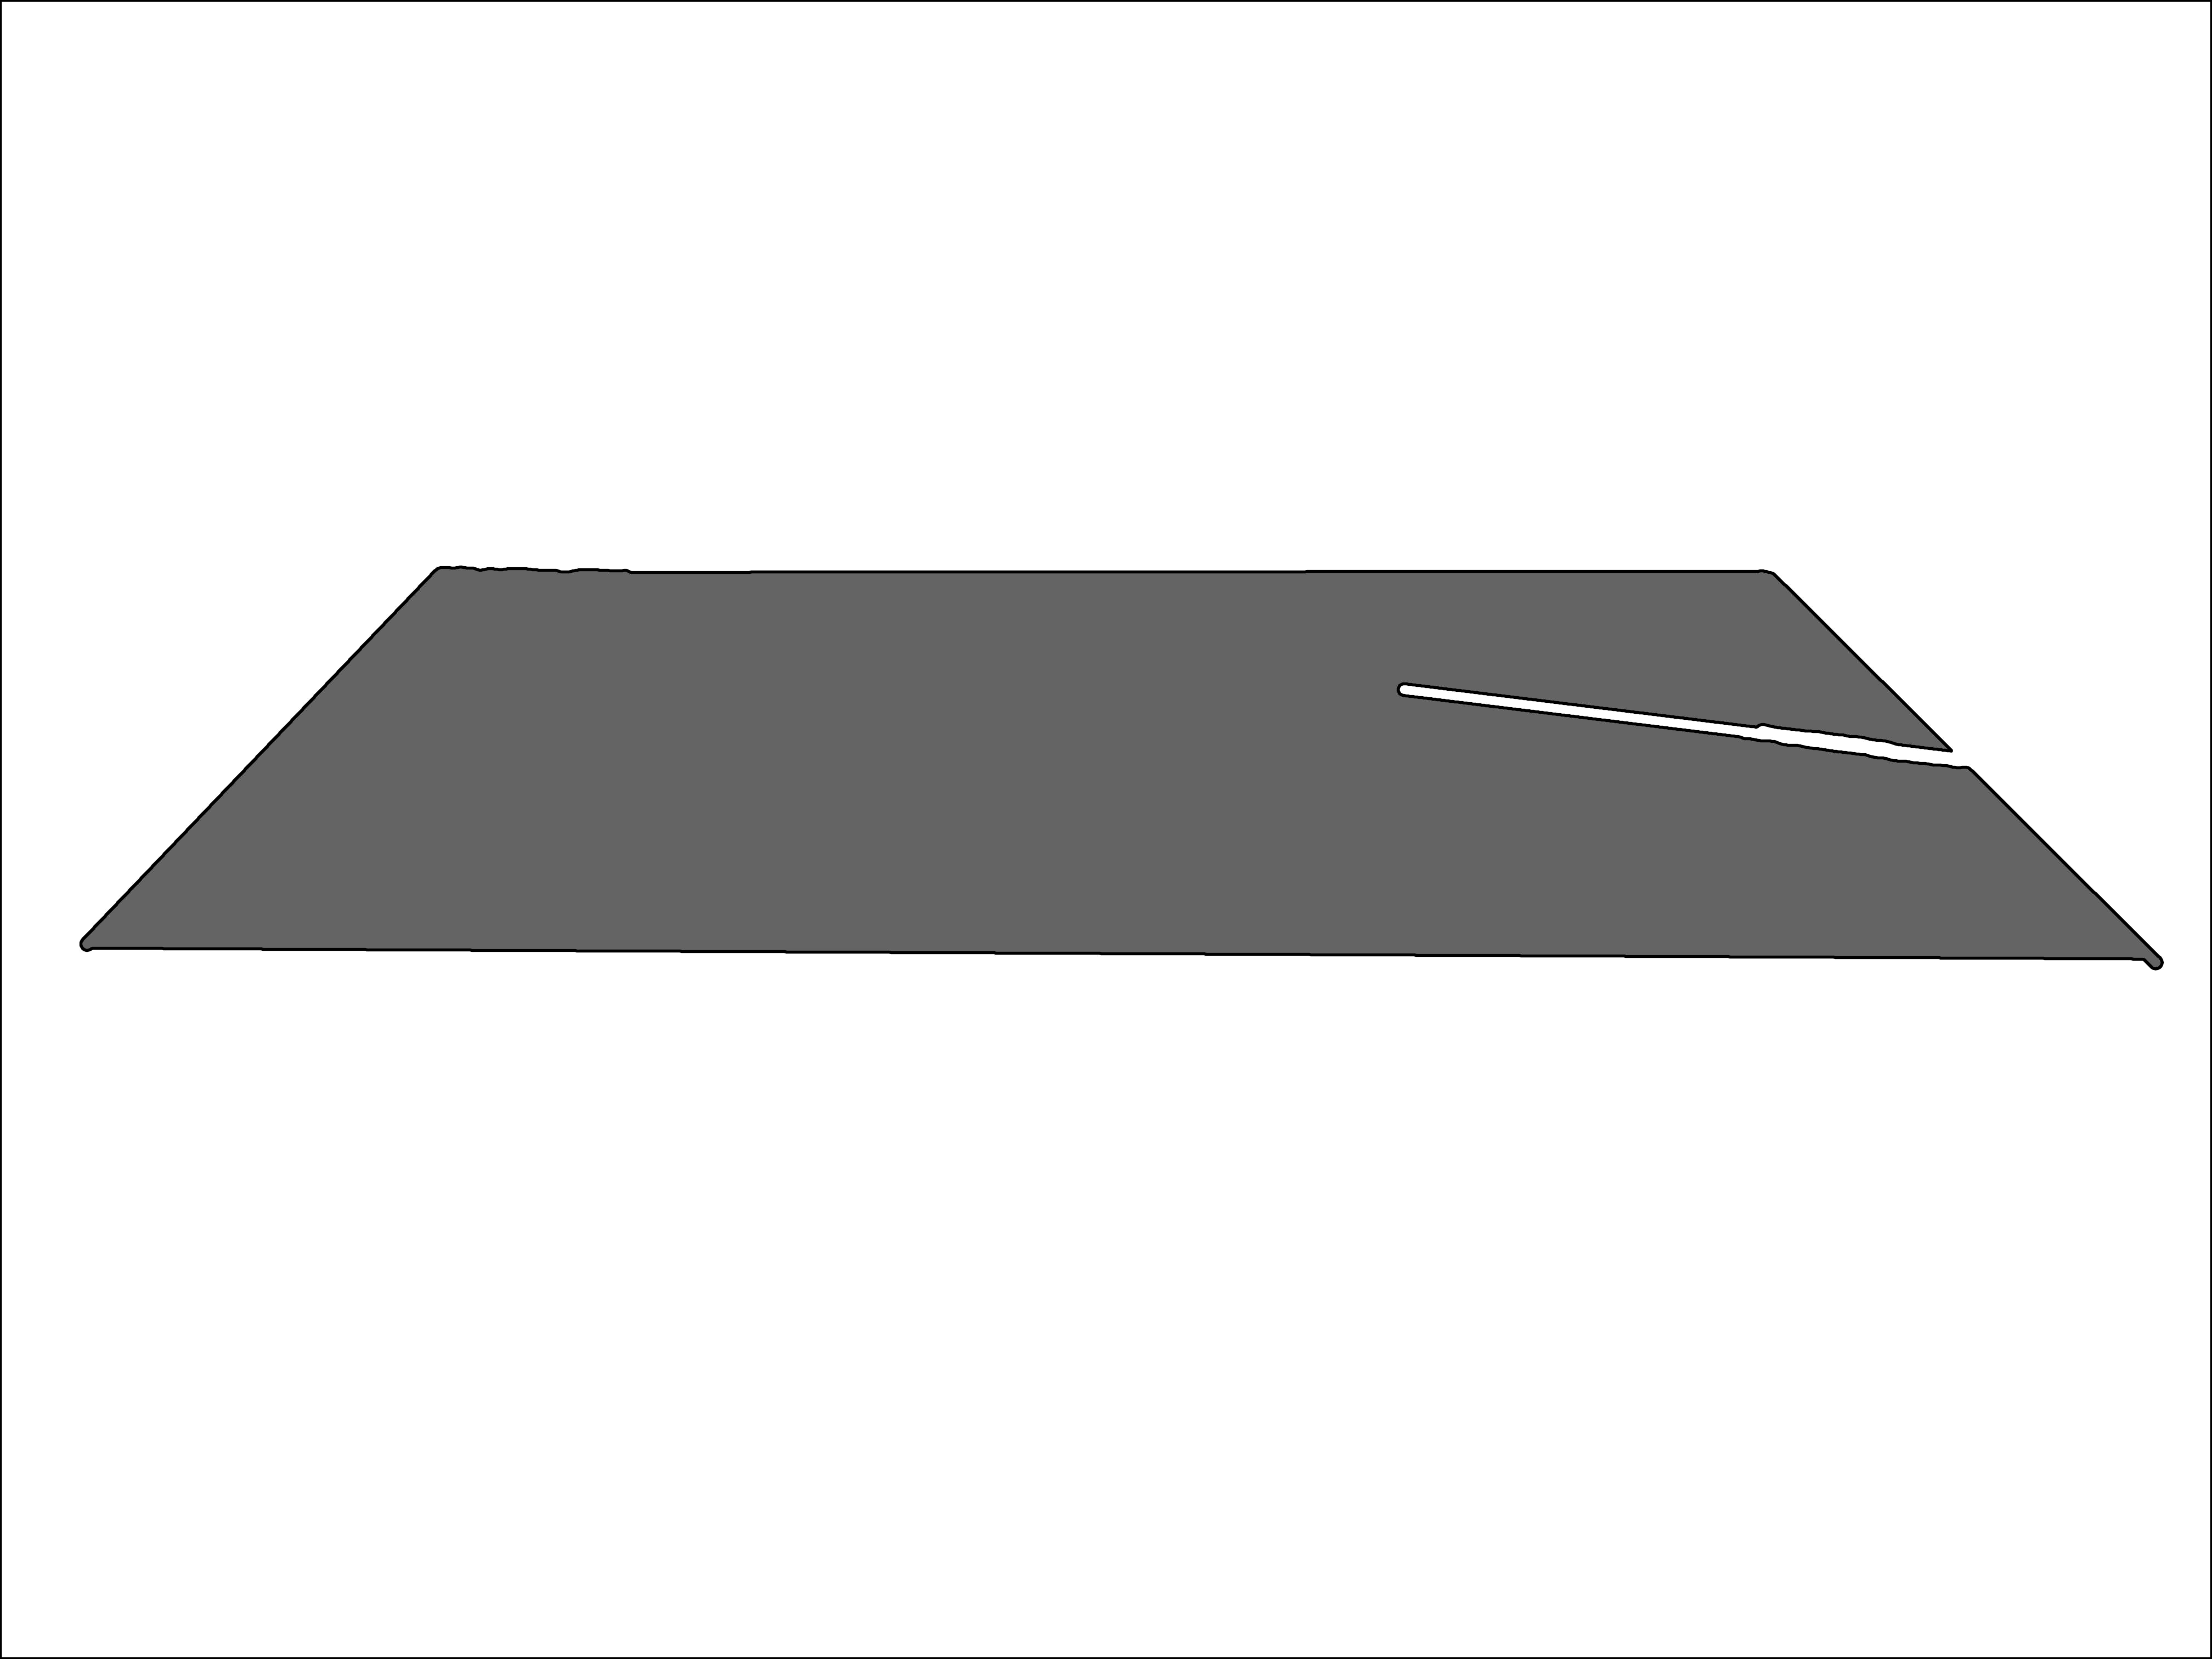

In [ ]:
to_table_dict = {0:255, 1:100, 2:100, 3:255}
mat = np.vectorize(to_table_dict.get)(img_table).astype(float)
im = Image.fromarray(mat)
im.convert('RGB').save('table_mask.jpg')
im = cv2.imread('table_mask.jpg', cv2.IMREAD_GRAYSCALE)
ret, thresh = cv2.threshold(im, 150, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
cv2.drawContours(image=im, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=3, lineType=cv2.LINE_AA)
cv2_imshow(im)


In [ ]:
pts = []
for i in range(1, len(contours)):
    pts.extend(np.squeeze(contours[i]))
pts = np.asarray(pts)
print(pts.shape)
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

top_left = pts[closest_node([0, 0], pts)]
bottom_left = pts[closest_node([0, height], pts)]
bottom_right = pts[closest_node([width, height], pts)]
top_right = pts[closest_node([width, 0], pts)]

start_pts = np.array([bottom_left, top_left, top_right, bottom_right])
end_pts = np.array([[100, 2500], [100, 500], [3932, 500], [3932, 2500]])
start_pts

(9666, 2)


array([[ 156, 1732],
       [ 793, 1039],
       [3232, 1045],
       [3929, 1766]], dtype=int32)

In [ ]:
def homography(img_mask, 
               startpts = np.matrix('80 1750; 750 1050; 3200 1050; 3850 1750'),
               endpts = np.array([[0, 2500], [0, 500], [4000, 500], [4000, 2500]])):
  # np.set_printoptions(precision=3)
  # np.set_printoptions(suppress=True)

  A = np.zeros([8, 9])
  N = startpts.shape[0]
  for i in range(N):
    x, y = startpts[i, 0], startpts[i, 1]
    x_, y_ = endpts[i, 0], endpts[i, 1]
    row0 = np.array([-x, -y, -1, 0, 0, 0, x_*x, x_*y, x_])
    row1 = np.array([0, 0, 0, -x, -y, -1, y_*x, y_*y, y_])
    A[2*i] = row0
    A[2*i+1] = row1
  U, S, V = np.linalg.svd(A)
  q = V[-1].T

  M = q.reshape((3,3))
  # img = np.asarray(image)
  warped_img1 = transform.warp(img_mask, inv(M))
  warped_img = np.rint(warped_img1).astype(int)
  plt.imshow(warped_img)
  plt.show()
  return warped_img

def detect_ball(warped_image):
  to_ball_dict = {0:255, 1:255, 2:1, 3:255}
  mat = np.vectorize(to_ball_dict.get)(warped_image).astype(float)
  mat = gaussian_filter(mat, sigma=10)
  im = Image.fromarray(mat)
  im.convert('RGB').save('ball_blob.jpg')

  params = cv2.SimpleBlobDetector_Params()
  params.minThreshold = 0
  params.maxThreshold = 256
  params.thresholdStep = 1
  params.filterByArea = True
  params.minArea = 1500
  params.filterByCircularity = False
  params.minCircularity = 0.3
  params.filterByConvexity = True
  params.minConvexity = 0.8
  params.filterByInertia = False
  # params.minInertiaRatio = 0
  # params.maxInertiaRatio = 1

  detector = cv2.SimpleBlobDetector_create(params)
  im = cv2.imread('ball_blob.jpg', cv2.IMREAD_GRAYSCALE)

  keypts = detector.detect(im)
  im_with_keypoints = cv2.drawKeypoints(im, keypts, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  cv2_imshow(im_with_keypoints)
  return keypts, im_with_keypoints

def detect_stick(warped_image):
  to_stick_dict = {0:255, 1:255, 2:255, 3:1}
  mat = np.vectorize(to_stick_dict.get)(warped_image).astype(float)
  mat = gaussian_filter(mat, sigma=0)
  im = Image.fromarray(mat)
  im.convert('RGB').save('stick_blob.jpg')

  params = cv2.SimpleBlobDetector_Params()
  params.minThreshold = 0
  params.maxThreshold = 256
  params.thresholdStep = 1
  params.filterByArea = False
  params.minArea = 1500
  params.filterByCircularity = False
  params.minCircularity = 0.3
  params.filterByConvexity = False
  params.minConvexity = 0.8
  params.filterByInertia = False
  # params.minInertiaRatio = 0
  # params.maxInertiaRatio = 1

  detector = cv2.SimpleBlobDetector_create(params)
  im = cv2.imread('stick_blob.jpg', cv2.IMREAD_GRAYSCALE)

  keypts = detector.detect(im)
  im_with_keypoints = cv2.drawKeypoints(im, keypts, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  cv2_imshow(im_with_keypoints)
  return keypts, im_with_keypoints

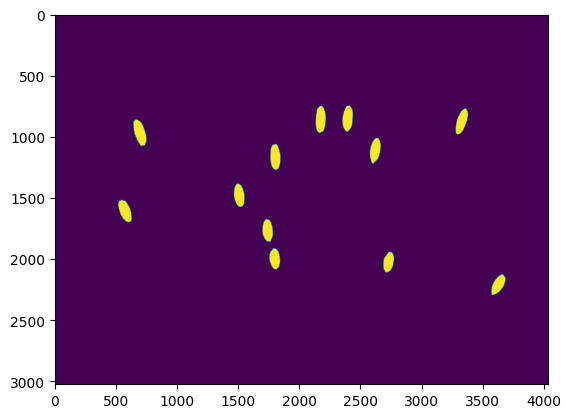

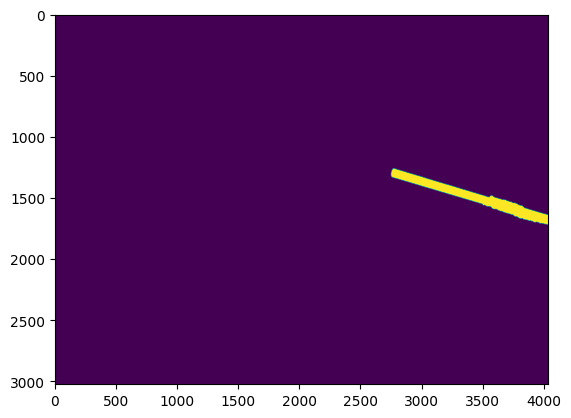

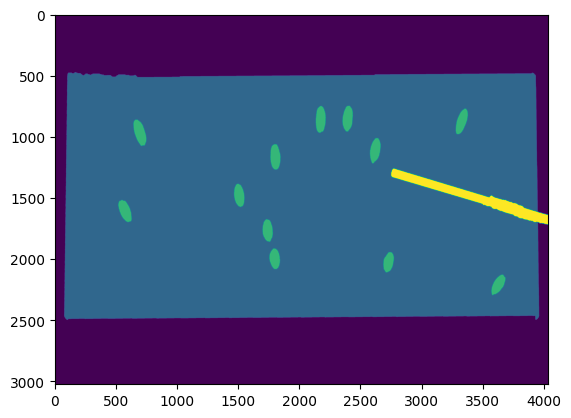

In [ ]:
warped_ball = homography(img_ball, start_pts, end_pts)
warped_stick = homography(img_stick, start_pts, end_pts)
warped_table = homography(img_table, start_pts, end_pts)

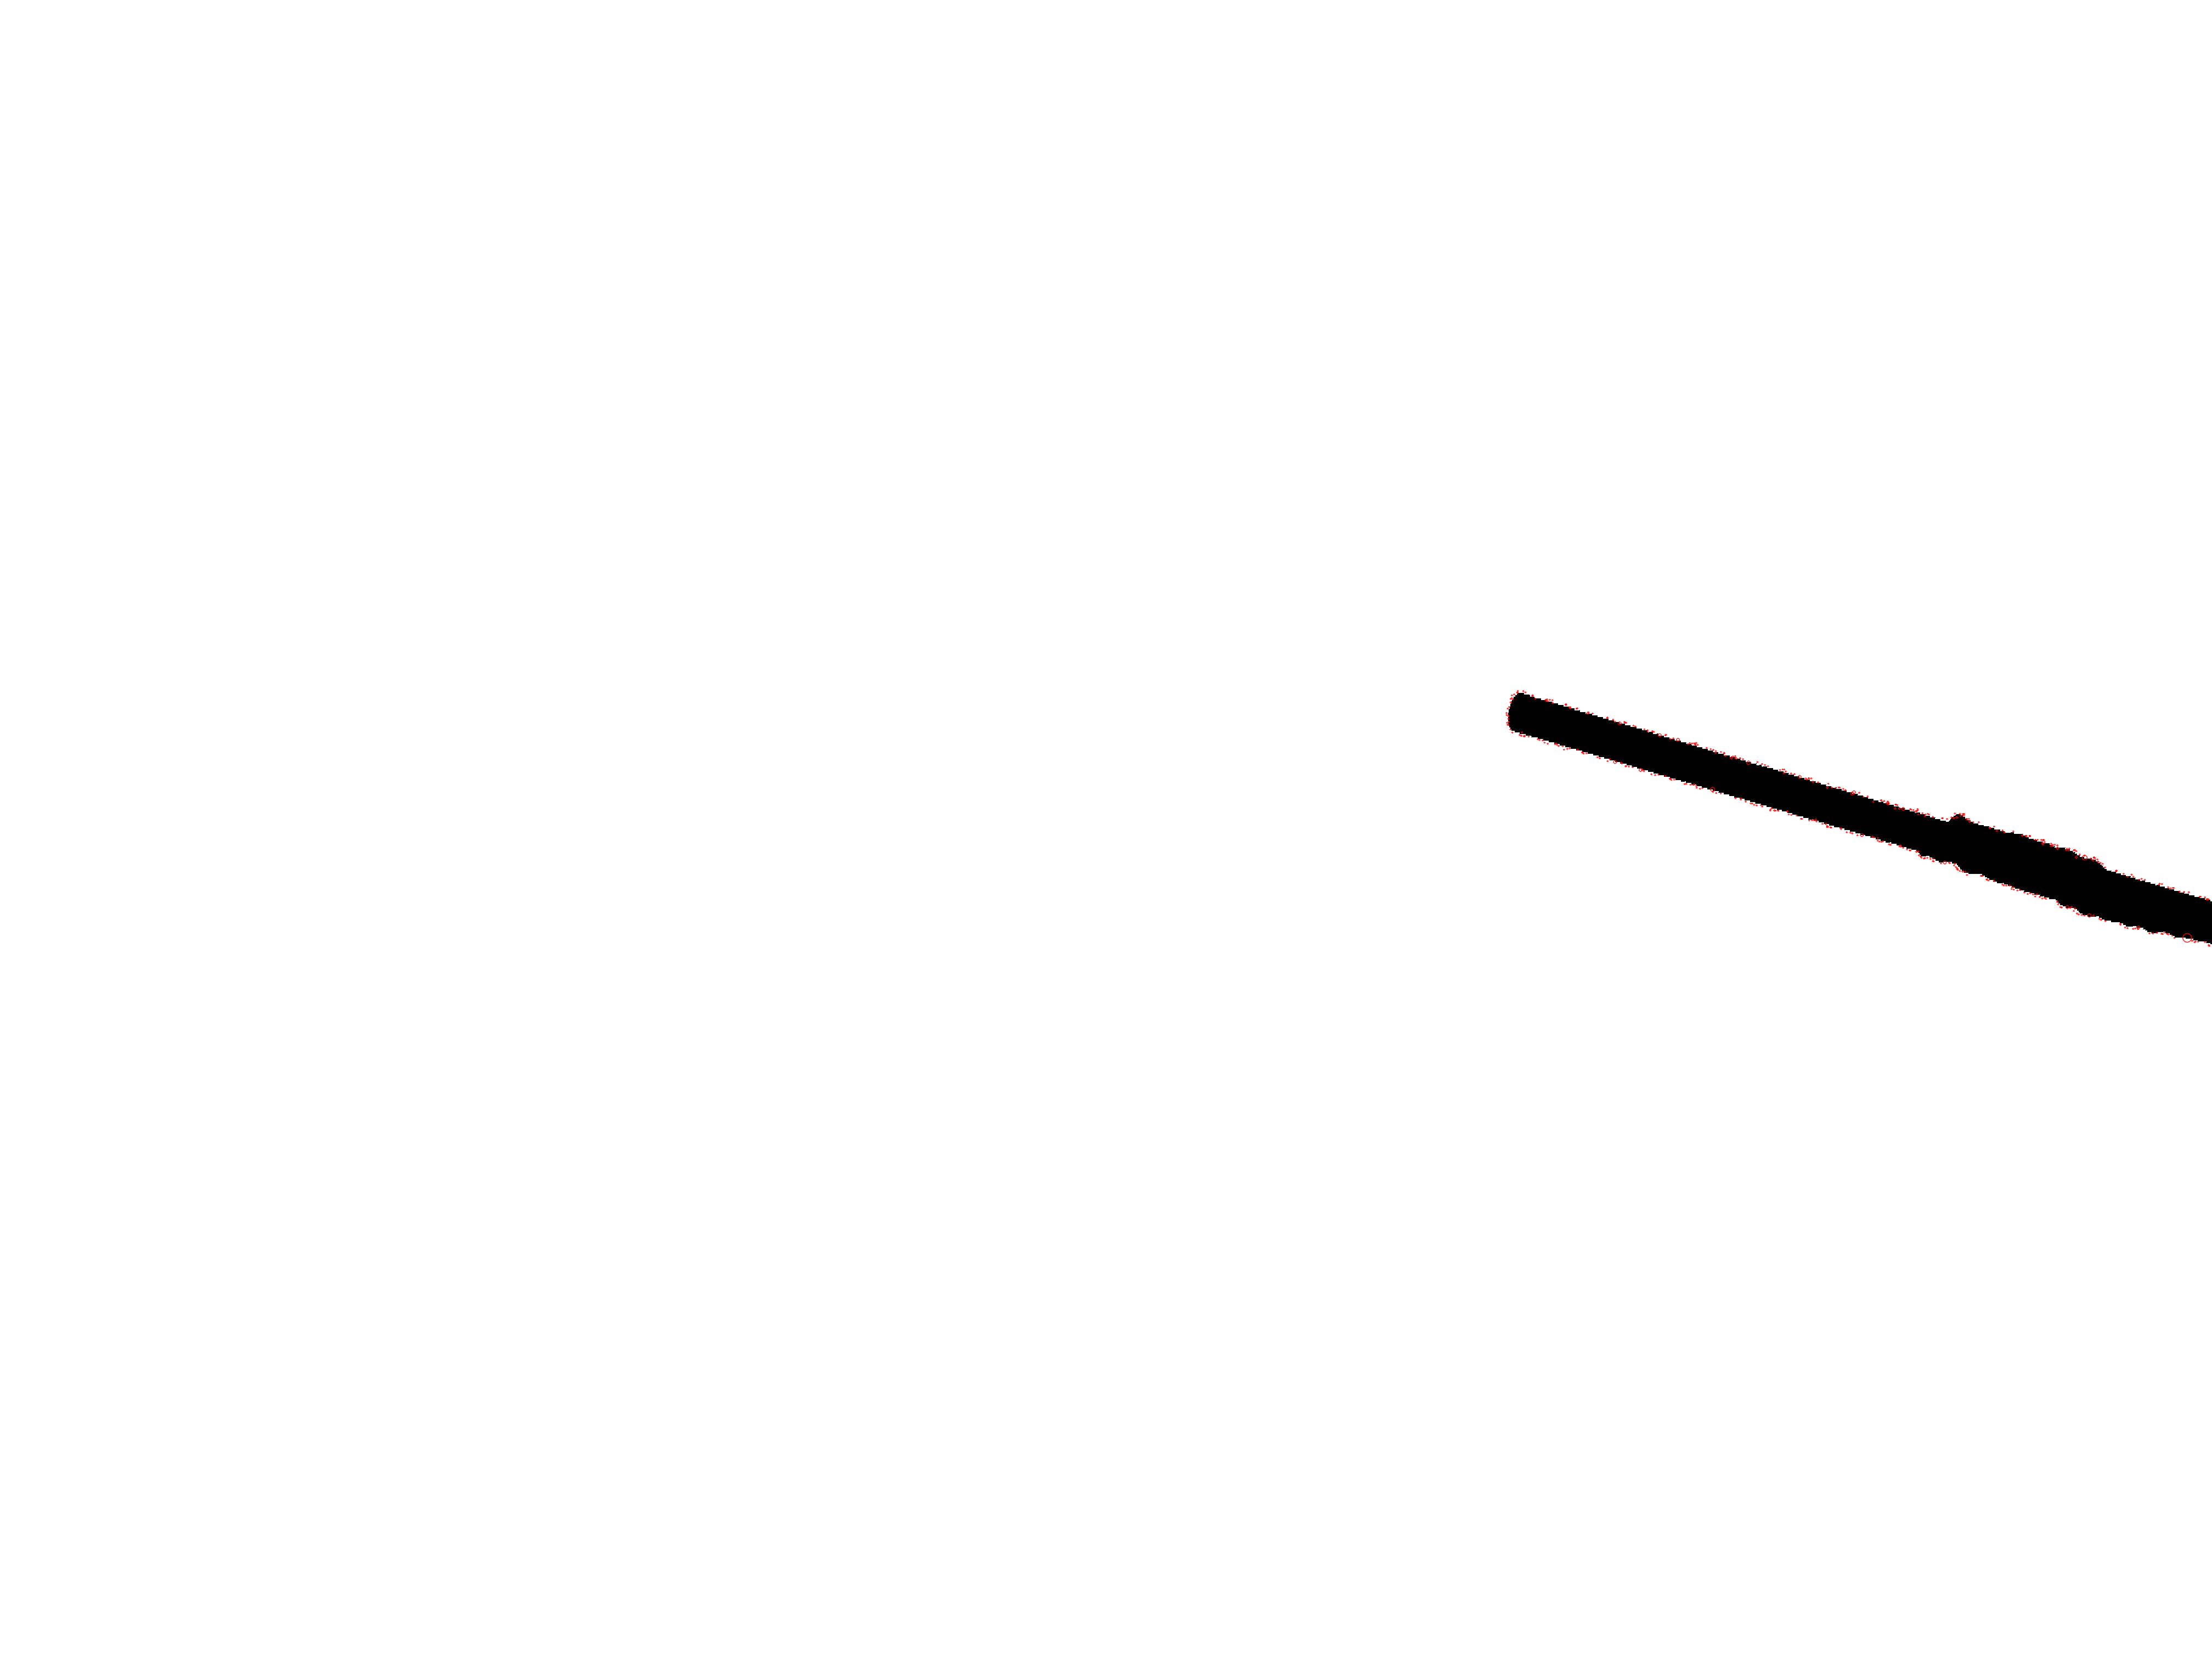

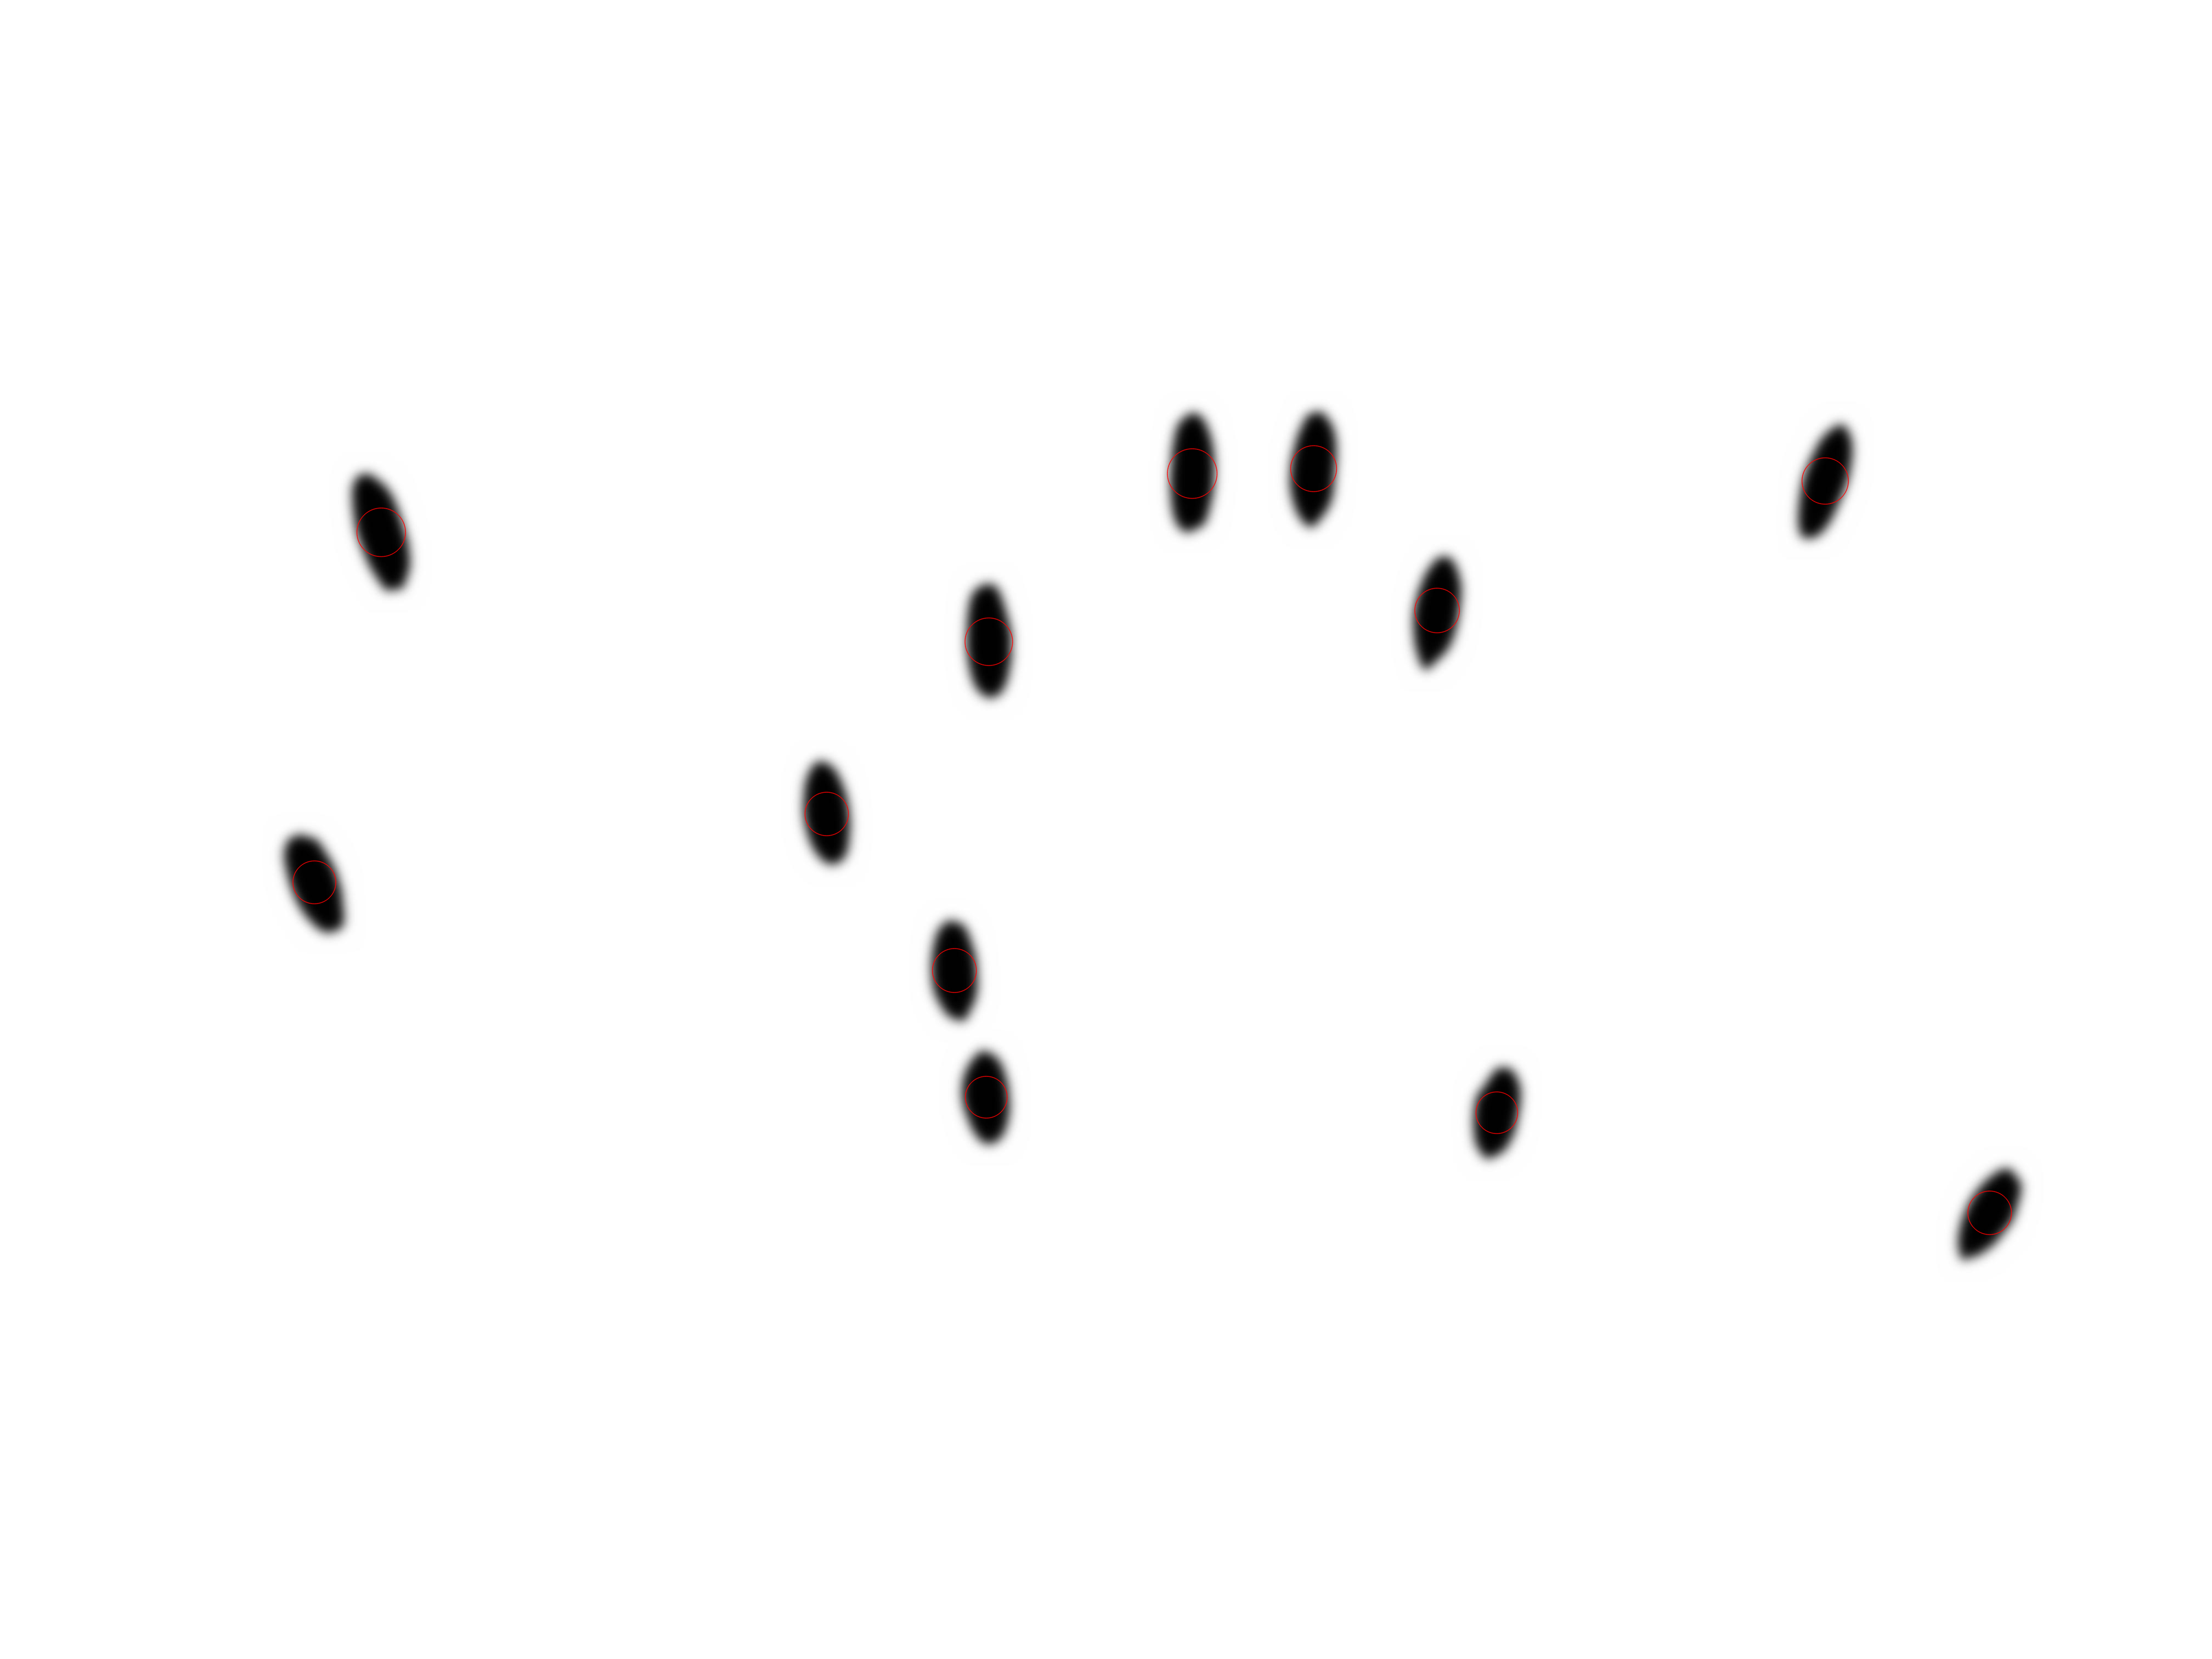

In [ ]:
# print(np.count_nonzero(warped_stick == 3))
stick_keys, stick_with_keypts = detect_stick(warped_stick)

ball_keys, ball_with_keypts = detect_ball(warped_ball)

ball_coords = []
for kpt in ball_keys:
  ball_coords.append(kpt.pt)

stick_pts = []
for kpt in stick_keys:
  stick_pts.append(kpt.pt)

In [ ]:
# CODE to get linear set of points for plotting
# RISHIKA :)
from scipy.special import i1e
def best_fit(stick_pts):
    stick_x = []
    stick_y = []
    for i in stick_pts:
      stick_x.append(i[0])
      stick_y.append(i[1])
    
    stick_x = np.array(stick_x)
    stick_y = np.array(stick_y)

    m = (((mean(stick_x)*mean(stick_y)) - mean(np.multiply(stick_x,stick_y))) / ((mean(stick_x)*mean(stick_x)) - mean(np.multiply(stick_x,stick_x))))
    b = mean(stick_y) - m*mean(stick_x)
    
    extremepoints = []
    if abs(m) < 1:
      min_x = min(stick_x)
      max_x = max(stick_x)
      extremepoints.append(tuple((min_x, min_x * m + b)))
      extremepoints.append(tuple((max_x, max_x * m + b)))

    else:
      min_y = min(stick_y)
      max_y = max(stick_y)
      extremepoints.append(tuple(((min_y - b) / m, min_y)))
      extremepoints.append(tuple(((max_y - b) / m, max_y)))
    
    return extremepoints

In [ ]:
def best_fit_extrema(stick_pts):
    stick_x = []
    stick_y = []
    for i in stick_pts:
      stick_x.append(i[0])
      stick_y.append(i[1])
    
    stick_x = np.array(stick_x)
    stick_y = np.array(stick_y)

    m = (((mean(stick_x)*mean(stick_y)) - mean(np.multiply(stick_x,stick_y))) / ((mean(stick_x)*mean(stick_x)) - mean(np.multiply(stick_x,stick_x))))
    b = mean(stick_y) - m*mean(stick_x)

    extremepoints = []
    #print(m)
    if m > 0:
      i1 = np.argmin(stick_x)
      i2 = np.argmax(stick_y)
      j1 = np.argmax(stick_x)
      j2 = np.argmin(stick_y)

    else:
      i1 = np.argmin(stick_x)
      i2 = np.argmin(stick_y)
      j1 = np.argmax(stick_x)
      j2 = np.argmax(stick_y)

    return np.array([tuple((stick_x[i1], stick_y[i1])), tuple((stick_x[i2], stick_y[i2])), tuple((stick_x[j1], stick_y[j1])), tuple((stick_x[j2], stick_y[j2]))])
    # extremepoints.append( tuple((round((stick_x[i1] + stick_x[i2]) / 2) , round((stick_y[i1] + stick_y[i2]) / 2))) )
    # extremepoints.append( tuple((round((stick_x[j1] + stick_x[j2]) / 2) , round((stick_y[j1] + stick_y[j2]) / 2))) )

    # return extremepoints

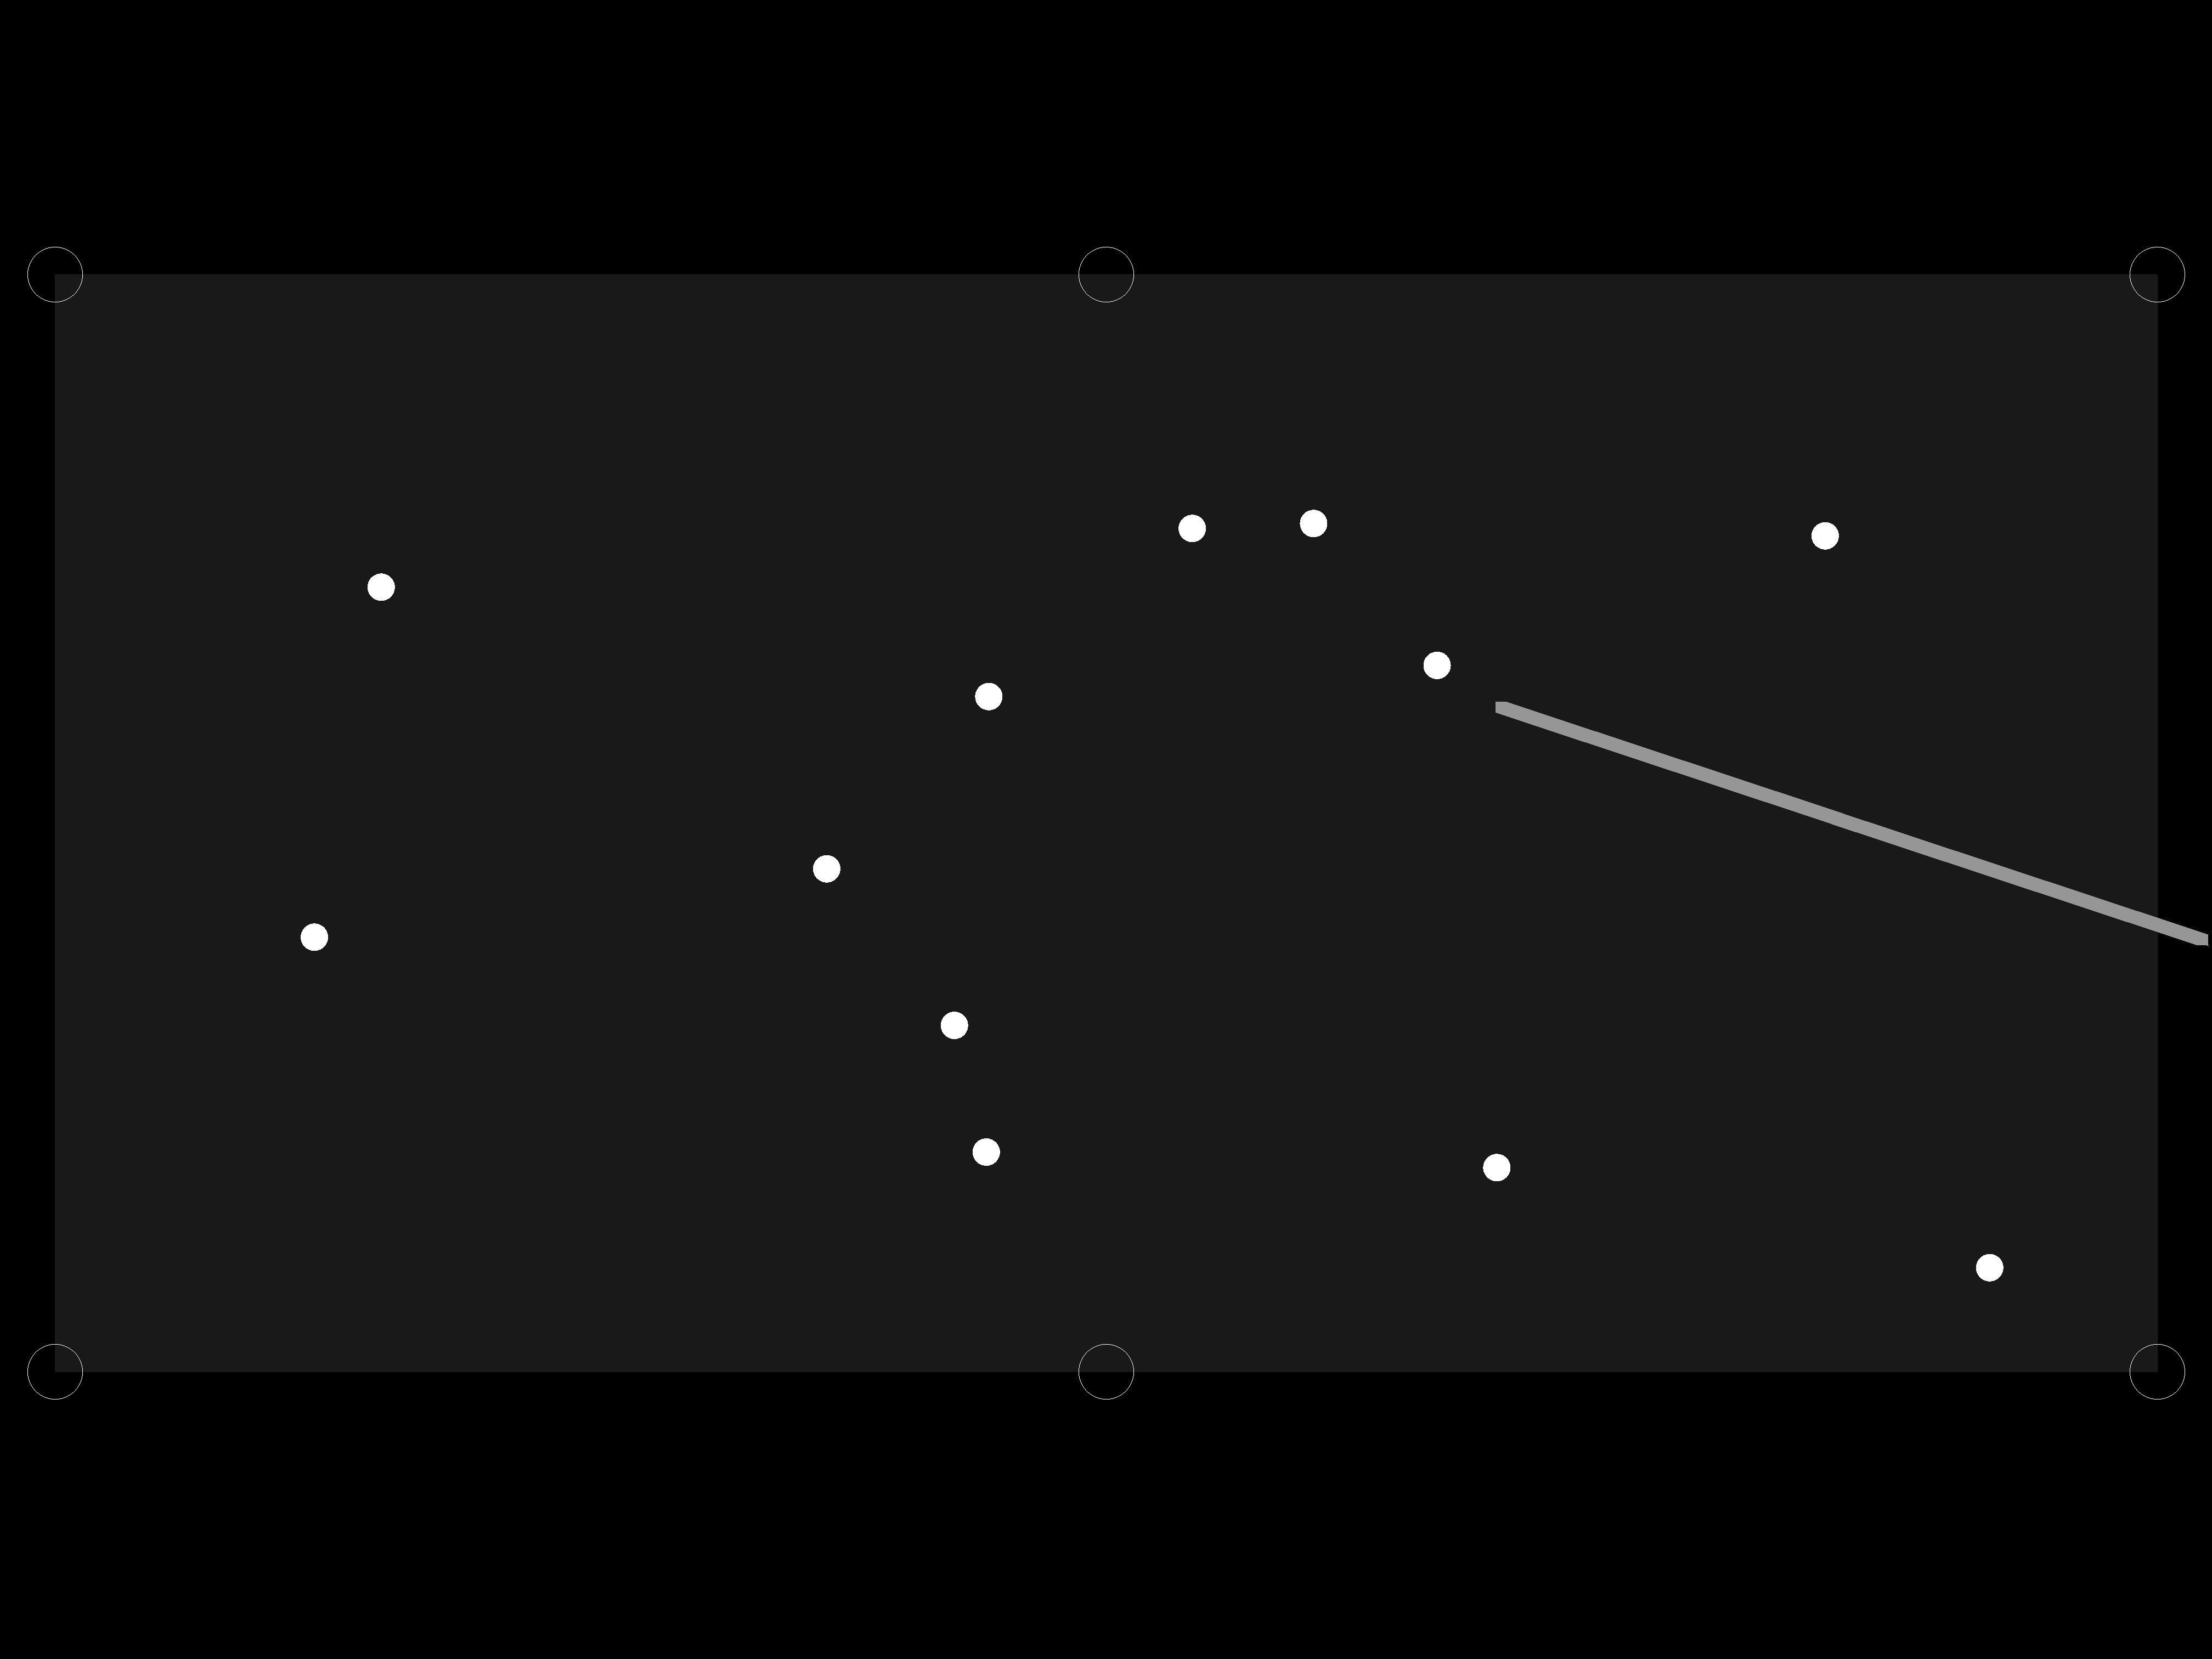

In [ ]:
grid = np.zeros([width, height])

r = end_pts[:,0]
c = end_pts[:,1]
rr, cc = draw.polygon(r, c)
grid[rr, cc] = 25

for pt in ball_coords:
  pt_t = [pt[0], pt[1] + 100] # ball offset 100 pixels
  rr, cc = draw.disk(pt_t, 25, shape=grid.shape)
  grid[rr, cc] = 255


stick_extremes = best_fit_extrema(stick_pts)

rr, cc = draw.line_nd(stick_extremes[0], stick_extremes[1])
grid[rr, cc] = 150
# r = stick_extremes[:,0]
# c = stick_extremes[:,1]
# rr, cc = draw.polygon(r, c)
# grid[rr, cc] = 150
for i in range (-20,0):
  for j in range(-20, 0):
    grid[rr+i, cc+j] = 150

mid_pockets = np.zeros([2, 2])
mid_pockets[0] = (end_pts[0] + end_pts[3]) / 2
mid_pockets[1] = (end_pts[1] + end_pts[2]) / 2
mid_pockets = mid_pockets.round().astype(int)
pockets = np.concatenate((end_pts, mid_pockets), axis=0)

for pocket in pockets:
  rr, cc = draw.circle_perimeter(pocket[0], pocket[1], 50)
  grid[rr, cc] = 255

im = Image.fromarray(grid.transpose())
im.show()

In [ ]:
len(ball_coords)

12

In [ ]:
def cue_stick_extreme_points():
  stick_extremes = best_fit_extrema(stick_pts)
  return stick_extremes

def direction_vector_cue_stick(start_point, end_point):
  direction_vector = np.array(end_point) - np.array(start_point)
  x = direction_vector[0]
  y = direction_vector[1]
  if (abs(x) > abs(y)):
    max_coord = x
  else:
    max_coord = y
  
  if max_coord == x:
    if x > 0:
      return 'right'
    else:
      return 'left'

  if max_coord == y:
    if y > 0:
      return 'up'
    else:
      return 'down'

  return 'neither'

def determine_trajectory_end_point(direction_vector,m, b):
  if direction_vector == 'down' or direction_vector == 'up':
    if direction_vector == 'down':
      x = (500 - b) / m
      trajectory_end_point = [x, 500]
    else:
      x = (2500 - b) / m
      trajectory_end_point = [x, 2500]
  
  if direction_vector == 'left' or direction_vector == 'right':
    if direction_vector == 'left':
      x = (2500 - b) / m
      trajectory_end_point = [x, 2500]
    else:
      x = (500 - b) / m
      trajectory_end_point = [x, 500]

  return trajectory_end_point

def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]

def ang(lineA, lineB):
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    dot_prod = dot(vA, vB)
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    cos_ = dot_prod/magA/magB
    angle = math.acos(dot_prod/magB/magA)
    ang_deg = math.degrees(angle)%360
    
    if ang_deg-180>=0:
        return 360 - ang_deg
    else: 
        
        return ang_deg

def determine_length_constant(direction_vector):
  if (direction_vector == 'down' or direction_vector == 'up'):
    return 5
  else:
    return 39

82850.28040801277


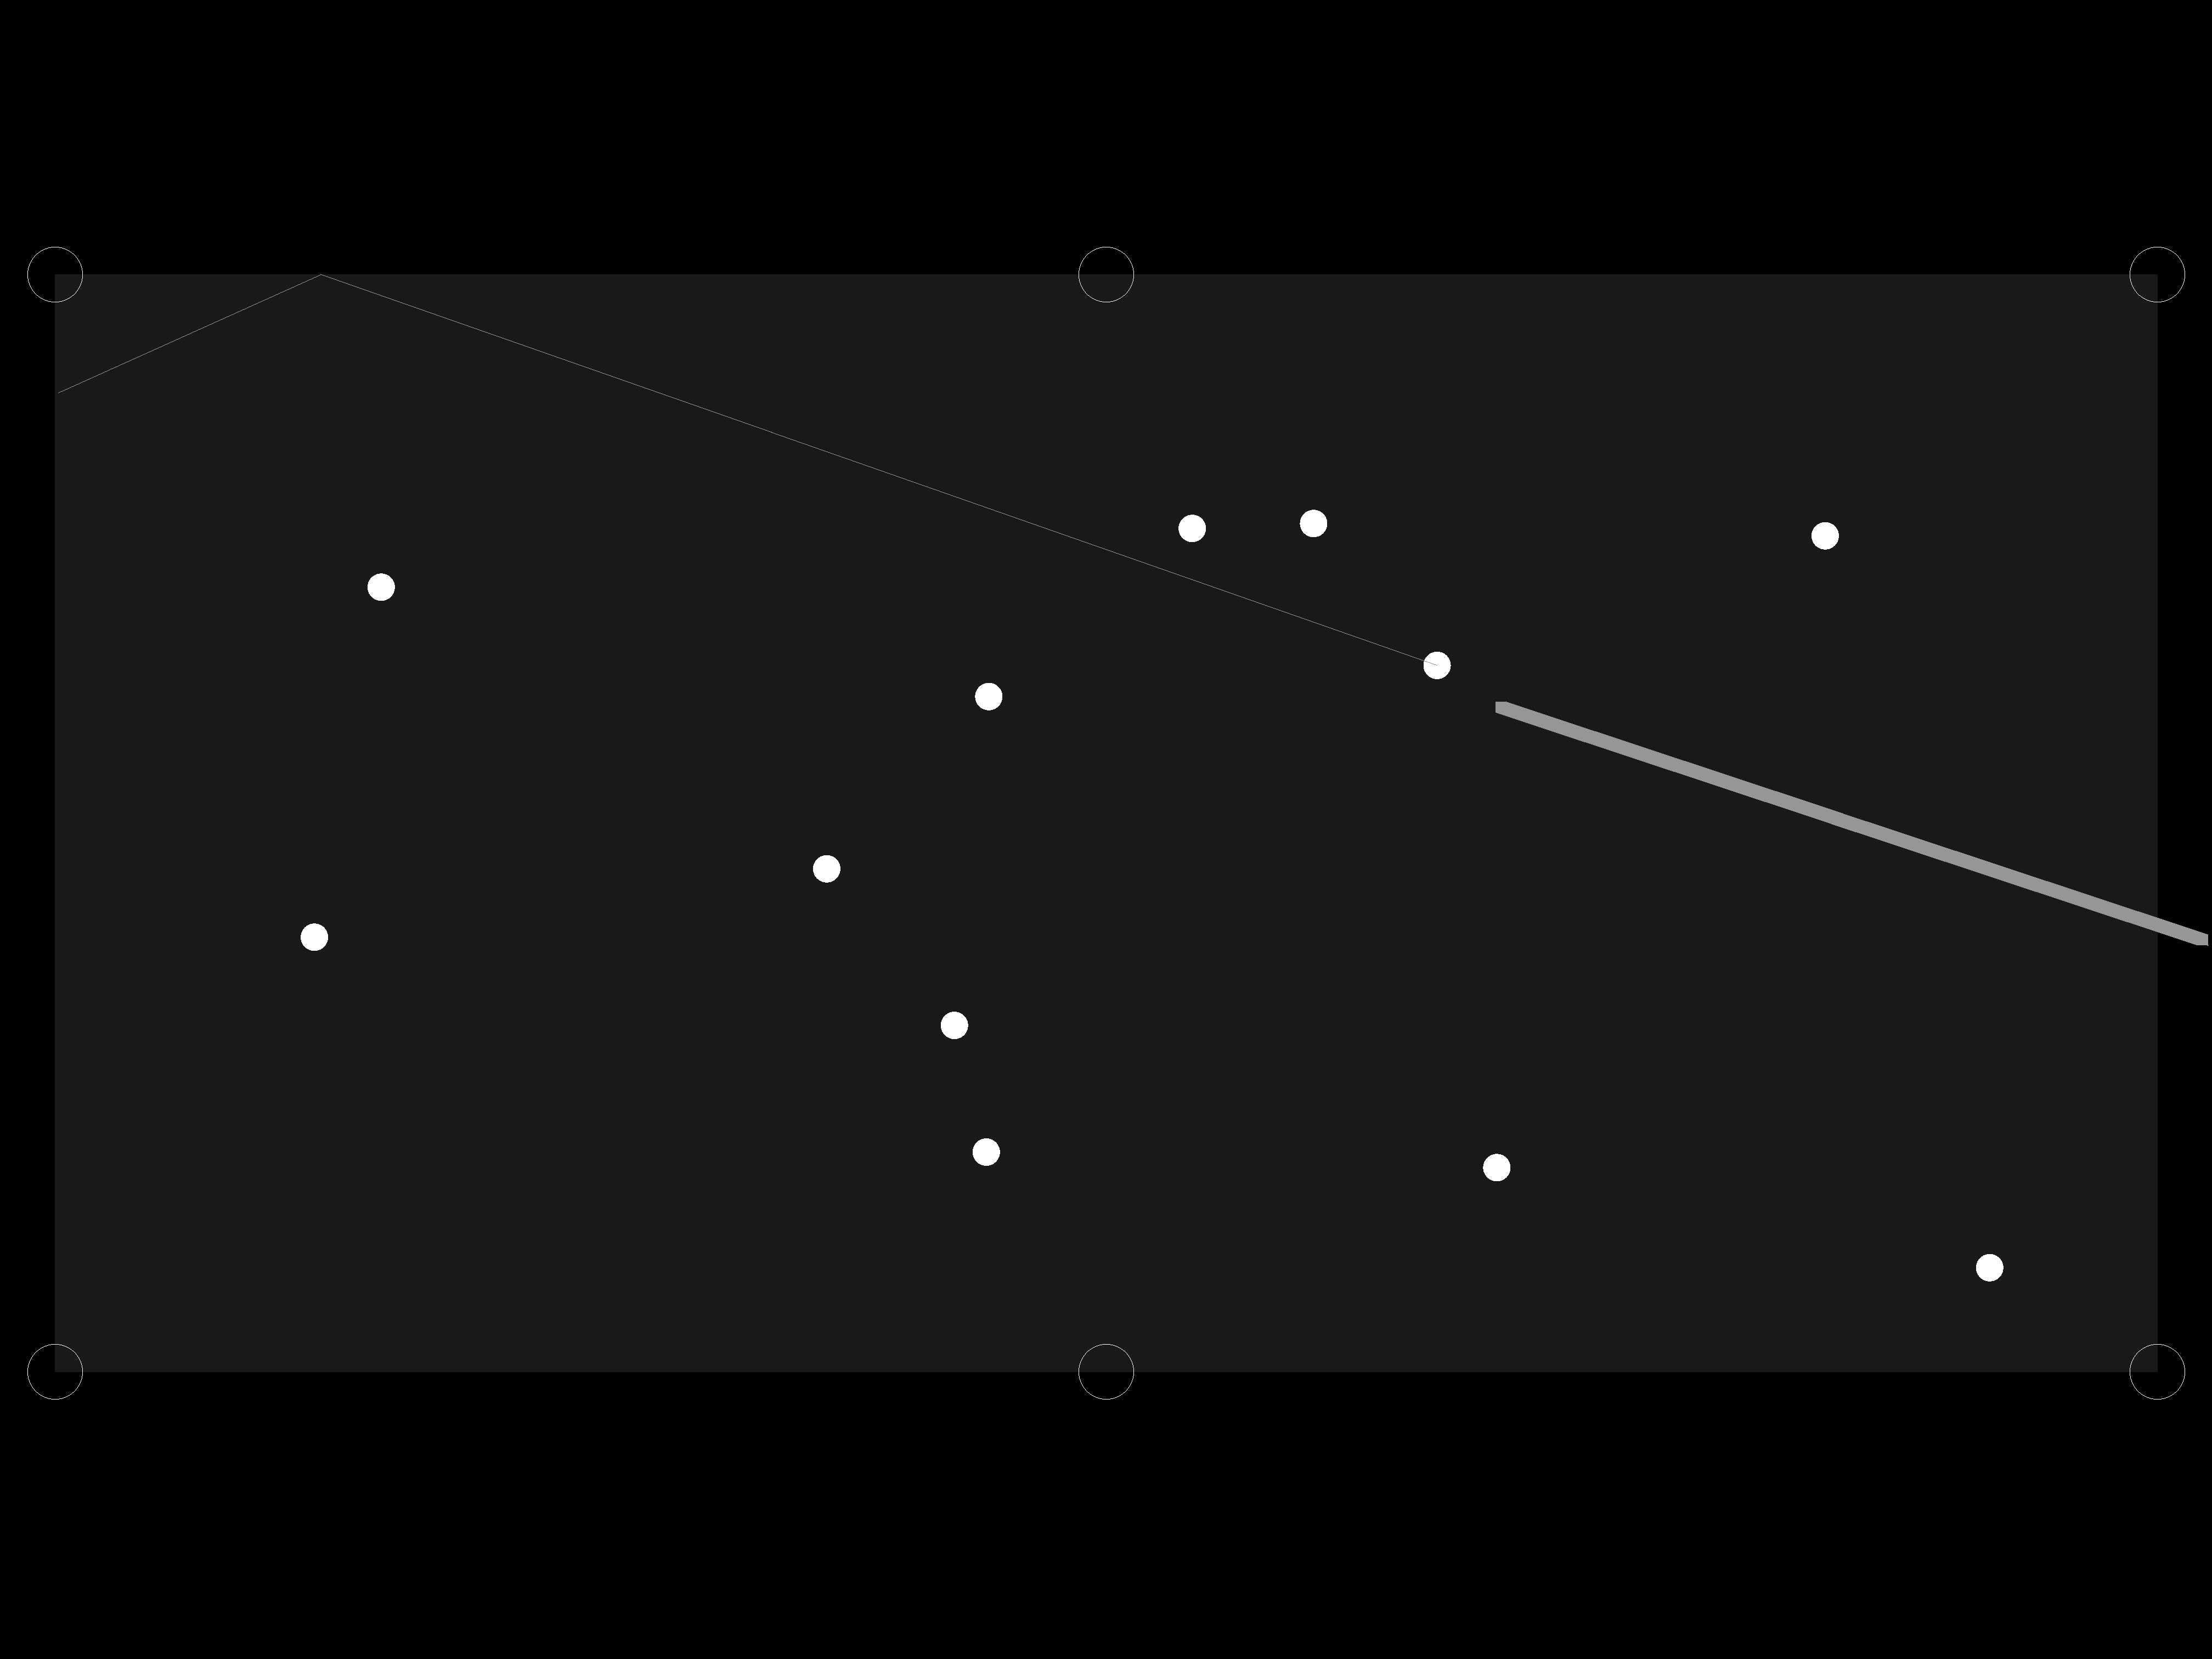

In [ ]:
#show pool table
grid = np.zeros([width, height])

r = end_pts[:,0]
c = end_pts[:,1]
rr, cc = draw.polygon(r, c)
grid[rr, cc] = 25

#show pool balls on the table
for pt in ball_coords:
  pt_t = [pt[0], pt[1] + 100] # ball offset 100 pixels
  rr, cc = draw.disk(pt_t, 25, shape=grid.shape)
  grid[rr, cc] = 255


points = cue_stick_extreme_points()
ball_in_cue_path = []
cue_stick_hit_ball = []
for i in points:
  for j in ball_coords:
    if (j[0] >= (int(i[0]) - 150) and j[0] <= (int(i[0]) + 150)) and (j[1] >= (int(i[1]) - 200) and j[1] <= (int(i[1]) + 200)) and j[0] not in ball_in_cue_path:
      ball_in_cue_path.append(j[0])
      cue_stick_hit_ball.append(i[0])

if (len(ball_in_cue_path) != 0):
  #find trajectory ball point coordinates
  trajectory_ball_point = []
  for el in ball_in_cue_path:
    for el_j in ball_coords:
      if el == el_j[0]:
        trajectory_ball_point.append([el_j[0], el_j[1]])

  #find ball in path coordinates
  ball_in_path = []
  for el in ball_in_cue_path:
    for el_j in ball_coords:
      if(el_j[0] == el):
        ball_in_path.append(el_j)

  #find slope of cue stick
  stick_x = []
  stick_y = []
  for i in stick_pts:
    stick_x.append(i[0])
    stick_y.append(i[1])
  stick_x = np.array(stick_x)
  stick_y = np.array(stick_y)
  m = (((mean(stick_x)*mean(stick_y)) - mean(np.multiply(stick_x,stick_y))) / ((mean(stick_x)*mean(stick_x)) - mean(np.multiply(stick_x,stick_x))))


  #determine direction of cue stick
  direction_vector = direction_vector_cue_stick(stick_extremes[0], stick_extremes[1])
  #find value of b 
  b = ball_in_path[0][1] - m * ball_in_path[0][0]

  #get trajectory end points 
  trajectory_end_point = determine_trajectory_end_point(direction_vector,m, b)

  #stick extreme points
  stick_extremes = best_fit_extrema(stick_pts)


  #get trajectory line to the pool table
  rr, cc = draw.line_nd((trajectory_ball_point[0][0], trajectory_ball_point[0][1] + 100), trajectory_end_point)
  grid[rr, cc] = 150


  lineA = [(trajectory_end_point[0], trajectory_end_point[1]), (trajectory_ball_point[0][0], trajectory_ball_point[0][1])]
  lineB = [(trajectory_end_point[0], trajectory_end_point[1]), ((trajectory_end_point[0], trajectory_ball_point[0][1]))]

  angle = -2 * ang(lineB, lineA)

  angle_radians = math.radians(angle)

  start_point = (trajectory_end_point[0], trajectory_end_point[1])

  start_point2 = (trajectory_end_point[0], trajectory_end_point[1])
  end_point2 = (trajectory_ball_point[0][0], trajectory_ball_point[0][1])

  delta_x2 = end_point2[0] - start_point2[0]
  delta_y2 = end_point2[1] - start_point2[1]
  length2 = math.sqrt(delta_x2 ** 2 + delta_y2 ** 2)
  direction_vector2 = (delta_x2 / length2, delta_y2 / length2)

  direction_vector1 = (math.cos(angle_radians) * direction_vector2[0] - math.sin(angle_radians) * direction_vector2[1],
                      -math.sin(angle_radians) * direction_vector2[0] + math.cos(angle_radians) * direction_vector2[1])


  len_multiply = determine_length_constant(direction_vector)

  length1 = len_multiply * length2
  end_point1 = (start_point[0] + length1 * direction_vector1[0],
                start_point[1] + length1 * direction_vector1[1])


  trajectory_slope = (start_point[1] - length1 * direction_vector1[1] - trajectory_end_point[1]) / (start_point[0] + length1 * direction_vector1[0] - trajectory_end_point[0])

  ball_in_trajectory_path = []
  for el in ball_coords:
      y = el[1]
      res_y = trajectory_slope * el[0] + b
      if (y == res_y):
        ball_in_trajectory_path.append(el)

  print(length1)
  rr, cc = draw.line_nd(trajectory_end_point, (start_point[0] + 750 * direction_vector1[0], start_point[1] + 750 * direction_vector1[1]))
  grid[rr, cc] = 150

#   # if len(ball_in_trajectory_path) == 0:
#   #   rr, cc = draw.line_nd(trajectory_end_point, (start_point[0] + length1 * direction_vector1[0], start_point[1] + length1 * direction_vector1[1]))
#   #   grid[rr, cc] = 150
#   # else:
#   #   rr, cc = draw.line_nd(trajectory_end_point, ball_in_trajectory_path[0])
#   #   grid[rr, cc] = 150
  

rr, cc = draw.line_nd(stick_extremes[0], stick_extremes[1])
grid[rr, cc] = 150

for i in range (-20,0):
  for j in range(-20, 0):
    grid[rr+i, cc+j] = 150

for pocket in pockets:
  rr, cc = draw.circle_perimeter(pocket[0], pocket[1], 50)
  grid[rr, cc] = 255

im = Image.fromarray(grid.transpose())
im.show()
